In [1]:
import networkx as nx
from manim import *
import math

config.media_width = "100%"
config.verbosity = "WARNING"

![ciao](media/tree.jpg)


In [3]:
def xor_op(a, b):
    return '1' if (int(a) ^ int(b)) else '0'

def and_op(a, b):
    return '1' if (int(a) & int(b)) else '0'

def or_op(a, b):
    return '1' if (int(a) | int(b)) else '0'



In [4]:

def generic_run(selfi, network, **kwargs):
    null_label = kwargs['null_label'] if 'null_label' in kwargs else '-'
    (Network, layout, label_edges) = network.get()

    unet = Network.to_undirected()
    network.init_computation(46, 63)
    finished = False
    time = 0
    while not finished:
    #for time in range(0, 2*nbits):
        print(f'Iteration {time}')
        G = Graph.from_networkx(unet, layout=layout, labels={i : Network.nodes[i]['weight']['value'] for i in Network})
        selfi.add(G)
        if time == 0:
            texts = [Text(str(Network[u][v]['weight']['carry'])).next_to(label_edges[(u, v)])
                        for u, v in Network.edges]
            for i in texts:
                selfi.add(i)
        else:
            new_texts = [Text(str(Network[u][v]['weight']['carry'])).next_to(label_edges[(u, v)])
                        for u, v in Network.edges]
            selfi.play(*[Transform(t1, t2) for t1, t2 in zip(texts, new_texts)])
        selfi.wait(1)
        finished = not network.compute_iteration()
        time = time+1
    selfi.wait(3)



In [7]:
class linear_sum:
    def is_carry(self, v):
        return (v-1)%3==0
    
    def is_input(self, v):
        return not self.is_carry(v)
        

    def __init__(self, nbits, **kwargs):
        # nbits is the number of bits of the operation
        self.nbits = nbits
        self.Array = nx.DiGraph()
        
        #        23 22 21 20 19 18 27 16 15 14 13 12 11 10 9  8  7  6  5  4  3  2  1  0
        #        i  c  i  i  c  i  i  c  i  i  c  i  i  c  i  i  c  i  i  c  i  i  c  i
        # pos_x -12-11-10-9  -8 -7 -6 -5 -4 -3 -2 -1 0  1  2  3  4  5  6  7  8  9 10 11
        # pos_y  1  0  1  1  0  1  1  0  1  1  0  1  1  0  1  1  0  1  1  0  1  1  0  1
        for x in range(0, 3*self.nbits): # Input nodes
            #print(x)
            self.Array.add_node(x, weight = {'value': '.'})

        # Edges to compute the sum of input bits
        for x in range(1, 3*self.nbits, 3):
            #print(f'adding input edge ({x-1}, {x})')
            self.Array.add_edge(x-1, x, weight={"carry": '.'})
            #print(f'adding input edge ({x+1}, {x})')
            self.Array.add_edge(x+1, x, weight={"carry": '.'})

        # Edges to propagate the carry
        for x in range(1, 3*(self.nbits-1), 3):
            #print(f'adding carry edge ({x}, {x+3})')
            self.Array.add_edge(x, x+3, weight={"carry": '.'})

        self.layout = { x: [3*nbits/2-x, 0 if (x-1)%3==0 else -1, 0] for x in range(0, 3*self.nbits)}
        print(self.layout)

        # Compute the positions of the labels for edges
        #        23 22 21 20 19 18 27 16 15 14 13 12 11 10 9  8  7  6  5  4  3  2  1  0
        #        i  c  i  i  c  i  i  c  i  i  c  i  i  c  i  i  c  i  i  c  i  i  c  i
        # Solution 1 for input edges: put then at the mean between the coordinates of the endpoints
        # Solution 1 for carry edges: put label on top and between the x coordinates of the endpoints
        edge_labels_x = {u: (self.layout[u][0]+self.layout[v][0])/2 for u, v in self.Array.edges}
        edge_labels_y = {}
        for u,v in self.Array.edges:
            if self.is_input(u):
                edge_labels_y[u] = (self.layout[u][1]+self.layout[v][1])/2
            else:
                edge_labels_y[u] = 0.3
        self.labels_position = {(u, v): edge_labels_x[u]*RIGHT+edge_labels_y[u]*UP for u, v in self.Array.edges}

    def get(self):
        return (self.Array, self.layout, self.labels_position)

    def init_computation(self, a, b):
        f = "{0:0"+str(self.nbits)+"b}"
        self.a = f.format(a)
        self.b = f.format(b)
        print(self.a, self.b)

        for i in range(0, 3*self.nbits, 3):
            self.Array.nodes[i]['weight']['value'] = self.a[self.nbits-1-int(i/3)]
            self.Array.nodes[i+2]['weight']['value'] = self.b[self.nbits-1-int(i/3)]

    def compute_iteration(self):
        some_updates = False

        for node in range(3*self.nbits-1, -1, -1):

            if self.is_input(node):
                for u, v, d in self.Array.out_edges(node, data=True):
                    assert(u==node)
                    if self.Array.nodes[node]['weight']['value'] != '.':
                        some_updates = True
                        #print(f'before: node {node}, edge ({u}, {v}), weigth {d} = {self.Array.nodes[node]['weight']['value']}')
                        d['weight']['carry'] = self.Array.nodes[node]['weight']['value']
                        self.Array.nodes[node]['weight']['value'] = '.'
                        #print(f'after:  node {node}, edge ({u}, {v}), weigth {d} = {self.Array.nodes[node]['weight']['value']}')
            else:
                #print("main computaiton")
                in_edges = [d for u, v, d in self.Array.in_edges(node, data=True)]
                in_edges_full = [(d, u, v) for u, v, d in self.Array.in_edges(node, data=True)]
                # check is the comutation is ready to start
                all_set = True
                for e in in_edges_full:
                    #print(f'              edge ({e[1]}, {e[2]}) -> {e[0]['weight']['carry']}')
                    all_set = all_set and (e[0]['weight']['carry'] != '.')
                #print (f'everything ok for node {node}? {all_set}')
                if all_set:
                    some_updates = True
                    if (node==1): # it has only two incoming edges
                        #print("I'm here")
                        assert(len(in_edges) == 2)
                        a = in_edges[0]['weight']['carry']
                        b = in_edges[1]['weight']['carry']
                        in_edges[0]['weight']['carry'] = '.'
                        in_edges[1]['weight']['carry'] = '.'
                        self.Array.nodes[node]['weight']['value'] = xor_op(a, b)
                        for u, v, d in self.Array.out_edges(node, data=True):
                            d['weight']['carry'] = and_op(a, b)
                    else:
                        #print("I'm not here")
                        assert(len(in_edges) == 3)
                        a = in_edges[0]['weight']['carry']
                        b = in_edges[1]['weight']['carry']
                        c = in_edges[2]['weight']['carry']
                        in_edges[0]['weight']['carry'] = '.'
                        in_edges[1]['weight']['carry'] = '.'
                        in_edges[2]['weight']['carry'] = '.'
                        self.Array.nodes[node]['weight']['value'] = xor_op(xor_op(a, b), c)
                        for u, v, d in self.Array.out_edges(node, data=True):
                            d['weight']['carry'] = or_op(and_op(a, b), or_op(and_op(a, c), and_op(b, c)))
        return some_updates
                    

In [8]:
%%manim -qm ShowLinear

config.frame_width = 25


class ShowLinear(Scene):
    
    def construct(self):
        nbits = 8
        network = linear_sum(nbits)
        generic_run(self, network, null_label = ' ')


Manim Community v0.18.1

{0: [12.0, -1, 0], 1: [11.0, 0, 0], 2: [10.0, -1, 0], 3: [9.0, -1, 0], 4: [8.0, 0, 0], 5: [7.0, -1, 0], 6: [6.0, -1, 0], 7: [5.0, 0, 0], 8: [4.0, -1, 0], 9: [3.0, -1, 0], 10: [2.0, 0, 0], 11: [1.0, -1, 0], 12: [0.0, -1, 0], 13: [-1.0, 0, 0], 14: [-2.0, -1, 0], 15: [-3.0, -1, 0], 16: [-4.0, 0, 0], 17: [-5.0, -1, 0], 18: [-6.0, -1, 0], 19: [-7.0, 0, 0], 20: [-8.0, -1, 0], 21: [-9.0, -1, 0], 22: [-10.0, 0, 0], 23: [-11.0, -1, 0]}
00101110 00111111
Iteration 0
Iteration 1


Iteration 2


Iteration 3


Iteration 4


Iteration 5


Iteration 6


Iteration 7


Iteration 8


Iteration 9


In [41]:
class tree_sum:
    def __init__(self, nbits, **kwargs):
        print(kwargs)
        self.null_label = kwargs['null_label'] if 'null_label' in kwargs else '-'

        # nbits is the number of bits of the operation
        # N is the number of nodes in the tree (2^n-1). Nodes in the tree will be from 0 to 2^n-2
        self.nbits = nbits
        self.N = 2*nbits-1
        self.Tree = nx.DiGraph()
        for x in range(0, self.N+2*self.nbits):
            #print(x)
            self.Tree.add_node(x, weight = {'value': self.null_label})

        for x in range(0,int(self.N/2)):
            #print(f'({x}, {x*2+1}), ({x}, {x*2+2})')
            # Edges parent to sons
            self.Tree.add_edge(x, x*2+1, weight={"carry": self.null_label, "dir": "down", "son": "left"})
            self.Tree.add_edge(x, x*2+2, weight={"carry": self.null_label, "dir": "down", "son": "right"})
            self.Tree.add_edge(x*2+1, x, weight={"carry": self.null_label, "all1s": self.null_label, "dir": "up", 'son': 'left'})
            self.Tree.add_edge(x*2+2, x, weight={"carry": self.null_label, "all1s": self.null_label, "dir": "up", 'son': 'right'})
            # Edges son to parent

        # Add edges for the real IO nodes
        for x in range(self.nbits-1, self.N):
            # self.Tree.add_edge(x, math.floor((x-(self.N+self.nbits))/2)+self.N+self.nbits, weight={"carry": self.null_label})
            print(f'{(x-self.nbits+1)*2+self.N}, {(x-self.nbits+1)*2+self.N + 1}')
            self.Tree.add_edge((x-self.nbits+1)*2+self.N,     x, weight={"carry": self.null_label, "dir": "up"})
            self.Tree.add_edge((x-self.nbits+1)*2+self.N + 1, x, weight={"carry": self.null_label, "dir": "up"})
    
        self.pos_y = [math.floor(math.log2(y+1)) - 2 for y in range(0, self.N)]
        self.pos_y = self.pos_y + [math.floor(math.log2(self.N+1)) - 2 for y in range(self.N, self.N+2*self.nbits)]
        
        self.pos_x = {x: x - self.N - self.nbits for x in range(self.N, self.N+2*self.nbits)}

        self.pos_x = {x: (self.pos_x[2*(x-self.nbits+1)+self.N]+self.pos_x[2*(x-self.nbits+1)+self.N+1])/2 for x in range(self.nbits-1, self.N)}|self.pos_x

        for level in range(int(math.log2(self.nbits))-1, -1, -1):
            self.pos_x = {x: (self.pos_x[x*2+1]+self.pos_x[x*2+2])/2 for x in range(2**level-1, 2**level-1+2**level)}|self.pos_x

        self.layout = { v: [self.pos_x[v], self.pos_y[v], 0] for v in range(0, self.N+2*self.nbits)}

        self.edges_labels_pos = { (u, v): [ (self.layout[u][0]+self.layout[v][0])/2, 
                                            (self.layout[u][1]+self.layout[v][1])/2,
                                            0]
                                    for u, v in self.Tree.edges }

    def is_input(self, v):
        return v in range(self.N, self.N+2*self.nbits)
    
    def is_output(self, v):
        return v in range(self.nbits-1, self.N)

    def is_internal_node(self, v):
        return v in range(0, self.nbits-1)

    def get(self):
        return (self.Tree, self.layout, self.edges_labels_pos)

    def init_computation(self, a, b):
        f = "{0:0"+str(self.nbits)+"b}"
        self.a = f.format(a)
        self.b = f.format(b)
        print(self.a, self.b)

        for x in range(self.N, self.N+2*self.nbits, 2): # more efficient that checking if a node is input
            # nodes are 2 by 2 holding one bit of a and 1 bit of b
            #print(f'node {x} and {x+1} setting bit {int((x-(self.N))/2)} from string {self.nbits-int((x-(self.N))/2)-1} = {self.a[self.nbits-int((x-(self.N))/2)-1]}')
            self.Tree.nodes[x]['weight']['value'] = self.a[self.nbits-int((x-(self.N))/2)-1]
            self.Tree.nodes[x+1]['weight']['value'] = self.b[self.nbits-int((x-(self.N))/2)-1]
            
    def compute_iteration(self):
        some_updates = False
        for node in self.Tree:
            if self.is_input(node):
                for u, v, d in self.Tree.out_edges(node, data=True):
                    assert(u==node)
                    if self.Tree.nodes[node]['weight']['value'] != self.null_label:
                        some_updates = True
                        d['weight']['carry'] = self.Tree.nodes[node]['weight']['value']
                        self.Tree.nodes[node]['weight']['value'] = self.null_label
            if self.is_output(node):
                #in_edges = [d for u, v, d in self.Tree.in_edges(node, data=True)]
                in_edges_full = [(d, u, v) for u, v, d in self.Tree.in_edges(node, data=True)]
                # check is the comutation is ready to start
                all_set = True
                relevant_edges = []
                for e in in_edges_full:
                    if e[0]['weight']['dir'] == 'up':
                        #print(f'              edge ({e[1]}, {e[2]}) -> {e[0]['weight']['carry']}')
                        all_set = all_set and (e[0]['weight']['carry'] != self.null_label)
                        relevant_edges.append(e)
                        #print (f'everything ok for node {node}? {all_set}')
                    else:
                        in_going_down = e
                #print(f'relevant_edges = {relevant_edges}')
                if all_set:
                    #print(f'     node {node} is being processed')
                    assert(len(relevant_edges) == 2)
                    some_updates = True
                    self.Tree.nodes[node]['weight']['value'] = xor_op(relevant_edges[0][0]['weight']['carry'], 
                                                                      relevant_edges[1][0]['weight']['carry'])
                    for u, v, d in self.Tree.out_edges(node, data=True):
                        if d['weight']['dir'] == 'up':
                            d['weight']['carry'] = and_op(relevant_edges[0][0]['weight']['carry'], 
                                                          relevant_edges[1][0]['weight']['carry'])
                            d['weight']['all1s'] = self.Tree.nodes[node]['weight']['value']
                    relevant_edges[0][0]['weight']['carry'] = self.null_label
                    relevant_edges[1][0]['weight']['carry'] = self.null_label
                if in_going_down[0]["weight"]["carry"] != self.null_label:
                    some_updates = True
                    self.Tree.nodes[node]['weight']['value'] = xor_op(self.Tree.nodes[node]['weight']['value'], 
                                                                      in_going_down[0]["weight"]["carry"])
                    in_going_down[0]["weight"]["carry"] = self.null_label

            if self.is_internal_node(node):
                # Going up
                # check if the computation is ready to start
                all_set = True

                for (u,v,e) in self.Tree.in_edges(node, data=True):
                    if (e['weight']['dir'] == 'up'):
                        print(f'node {node}              edge ({u}, {v}) -> {e['weight']['carry']}')
                        all_set = all_set and (e['weight']['carry'] != self.null_label)
                        if e['weight']['son'] == "left":
                            in_left = e
                        if e['weight']['son'] == "right":
                            in_right = e
                    if e['weight']['dir'] == "down":
                        print(f'{node} -> input edge ({u}, {v}) = {e['weight']['dir']}')
                        in_top = e
                for u, v, e in self.Tree.out_edges(node, data=True):
                    print(f'node {node} -> ({u}, {v}) -> {e}')
                    if e['weight']['son'] == 'left':
                        out_left = e
                    if e['weight']['son'] == 'right':
                        out_right = e
                    if e['weight']['dir'] == 'up':
                        out_up = e

                if all_set:
                    #print(f'     node {node} is being processed')
                    some_updates = True
                    # send left carry down to the right
                    out_right['weight']['carry'] = in_left['weight']['carry']
                    in_left['weight']['carry'] = self.null_label
                    # keep all1s in the node
                    self.Tree.nodes[node]['weight']['value'] = in_left['weight']['all1s']
                    # send right carry up
                    if (node != 0):
                        out_up['weight']['carry'] = in_right['weight']['carry']
                    in_right['weight']['carry'] = self.null_label

                # Going down
                if node != 0:
                    if in_top['weight']['carry'] == '1' or in_top['weight']['carry'] == '0':
                        if self.Tree.nodes[node]['weight']['value'] == '1':
                            out_left['weight']['carry'] = in_top['weight']['carry']
                            out_right['weight']['carry'] = in_top['weight']['carry']
                            in_top['weight']['carry'] = self.null_label
                        if self.Tree.nodes[node]['weight']['value'] == '0':
                            out_left['weight']['carry'] = in_top['weight']['carry']
                            in_top['weight']['carry'] = self.null_label
                        
        print(some_updates)
        return some_updates
        

In [42]:
%%manim -qm ShowTree

config.frame_width = 19
class ShowTree(Scene):
    
    def construct(self):
        nbits = 8
        network = tree_sum(nbits, null_label='-')
        generic_run(self, network, null_label='-')


Manim Community v0.18.1

{'null_label': '-'}
15, 16
17, 18
19, 20
21, 22
23, 24
25, 26
27, 28
29, 30
00101110 00111111
Iteration 0
node 0              edge (1, 0) -> -
node 0              edge (2, 0) -> -
node 0 -> (0, 1) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 0 -> (0, 2) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
1 -> input edge (0, 1) = down
node 1              edge (3, 1) -> -
node 1              edge (4, 1) -> -
node 1 -> (1, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'left'}}
node 1 -> (1, 3) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 1 -> (1, 4) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
2 -> input edge (0, 2) = down
node 2              edge (5, 2) -> -
node 2              edge (6, 2) -> -
node 2 -> (2, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'right'}}
node 2 -> (2, 5) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 2 -> (2, 6) -> {'weight': {'carry': '-', 

node 0              edge (1, 0) -> -
node 0              edge (2, 0) -> -
node 0 -> (0, 1) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 0 -> (0, 2) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
1 -> input edge (0, 1) = down
node 1              edge (3, 1) -> -
node 1              edge (4, 1) -> -
node 1 -> (1, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'left'}}
node 1 -> (1, 3) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 1 -> (1, 4) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
2 -> input edge (0, 2) = down
node 2              edge (5, 2) -> -
node 2              edge (6, 2) -> -
node 2 -> (2, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'right'}}
node 2 -> (2, 5) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 2 -> (2, 6) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
3 -> input edge (1, 3) = down
node 3              edge (7, 3) -> -
node 3 

node 0              edge (1, 0) -> -
node 0              edge (2, 0) -> -
node 0 -> (0, 1) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 0 -> (0, 2) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
1 -> input edge (0, 1) = down
node 1              edge (3, 1) -> -
node 1              edge (4, 1) -> -
node 1 -> (1, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'left'}}
node 1 -> (1, 3) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 1 -> (1, 4) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
2 -> input edge (0, 2) = down
node 2              edge (5, 2) -> -
node 2              edge (6, 2) -> -
node 2 -> (2, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'right'}}
node 2 -> (2, 5) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 2 -> (2, 6) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
3 -> input edge (1, 3) = down
node 3              edge (7, 3) -> 0
node 3 

node 0              edge (1, 0) -> -
node 0              edge (2, 0) -> -
node 0 -> (0, 1) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 0 -> (0, 2) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
1 -> input edge (0, 1) = down
node 1              edge (3, 1) -> 1
node 1              edge (4, 1) -> 1
node 1 -> (1, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'left'}}
node 1 -> (1, 3) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 1 -> (1, 4) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
2 -> input edge (0, 2) = down
node 2              edge (5, 2) -> 1
node 2              edge (6, 2) -> 0
node 2 -> (2, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'right'}}
node 2 -> (2, 5) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 2 -> (2, 6) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
3 -> input edge (1, 3) = down
node 3              edge (7, 3) -> -
node 3 

node 0              edge (1, 0) -> 1
node 0              edge (2, 0) -> 0
node 0 -> (0, 1) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 0 -> (0, 2) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
1 -> input edge (0, 1) = down
node 1              edge (3, 1) -> -
node 1              edge (4, 1) -> -
node 1 -> (1, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'left'}}
node 1 -> (1, 3) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 1 -> (1, 4) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
2 -> input edge (0, 2) = down
node 2              edge (5, 2) -> -
node 2              edge (6, 2) -> -
node 2 -> (2, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'right'}}
node 2 -> (2, 5) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 2 -> (2, 6) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
3 -> input edge (1, 3) = down
node 3              edge (7, 3) -> -
node 3 

node 0              edge (1, 0) -> -
node 0              edge (2, 0) -> -
node 0 -> (0, 1) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 0 -> (0, 2) -> {'weight': {'carry': '1', 'dir': 'down', 'son': 'right'}}
1 -> input edge (0, 1) = down
node 1              edge (3, 1) -> -
node 1              edge (4, 1) -> -
node 1 -> (1, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'left'}}
node 1 -> (1, 3) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 1 -> (1, 4) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
2 -> input edge (0, 2) = down
node 2              edge (5, 2) -> -
node 2              edge (6, 2) -> -
node 2 -> (2, 0) -> {'weight': {'carry': '-', 'all1s': '-', 'dir': 'up', 'son': 'right'}}
node 2 -> (2, 5) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'left'}}
node 2 -> (2, 6) -> {'weight': {'carry': '-', 'dir': 'down', 'son': 'right'}}
3 -> input edge (1, 3) = down
node 3              edge (7, 3) -> -
node 3 

In [ ]:
%%manim -qm ShowTree

config.frame_width = 14

class ShowTree(Scene):
    
    def construct(self):
        nbits = 8
        network = tree_sum(nbits)
        (Network, layout, label_edges) = network.get()
        unet = Network.to_undirected()
        #network.init_computation(46, 63)
        for time in range(0, 2):
            print(f'Iteration {time}')
            G = DiGraph.from_networkx(unet, layout=layout, layout_scale=2, labels={i : Network.nodes[i]['weight']['value'] for i in Network})
            self.add(G)
            if time == 0:
                texts = [Text(str(Network[u][v]['weight']['carry'])).next_to(label_edges[(u, v)])
                            for u, v in Network.edges]
                for i in texts:
                    self.add(i)
            else:
                new_texts = [Text(str(Network[u][v]['weight']['carry'])).next_to(label_edges[(u, v)])
                            for u, v in Network.edges]
                self.play(*[Transform(t1, t2) for t1, t2 in zip(texts, new_texts)])                
            self.wait(1)
            network.compute_node()
        self.wait(3)


Manim Community v0.18.1

Iteration 0
Iteration 1


In [ ]:
nbits = 8
a=46
b=63
c=a+b
f = "{0:0"+str(nbits)+"b}"
a = f.format(a)
b = f.format(b)
c = f.format(c)
print(a, b, c)


00101110 00111111 01101101


In [ ]:
[ f'{u} is a number' for u in range(1, 10)]


['1 is a number',
 '2 is a number',
 '3 is a number',
 '4 is a number',
 '5 is a number',
 '6 is a number',
 '7 is a number',
 '8 is a number',
 '9 is a number']

In [ ]:
x = {1: 3, 2: 4}|{4: 5}
print(x)

{1: 3, 2: 4, 4: 5}


In [ ]:
for x in range(1, 3*7, 3):
    print(f'{x} -> {x+3}')
print('------------')
for x in range(1, 3*8, 3):
    print(f'{x-1} -> {x}')
    print(f'{x+1} -> {x}')

1 -> 4
4 -> 7
7 -> 10
10 -> 13
13 -> 16
16 -> 19
19 -> 22
------------
0 -> 1
2 -> 1
3 -> 4
5 -> 4
6 -> 7
8 -> 7
9 -> 10
11 -> 10
12 -> 13
14 -> 13
15 -> 16
17 -> 16
18 -> 19
20 -> 19
21 -> 22
23 -> 22


In [ ]:
%%manim -qm ShowTree

class ShowTree(Scene):
    
    def construct(self):
        network = tree_sum(4)
        (Network, px, py, layout) = network.get()
        unet = Network.to_undirected()
        #network.init_computation(86, 123)
        for i in unet:
            print(f'u{i}: {layout[i]}')
        G = Graph.from_networkx(unet, layout=layout, layout_scale=3.5)
        self.play(Create(G))
        self.wait(10)


Manim Community v0.18.1

u0: [0.0, -2, 0]
u1: [-1.0, -1, 0]
u2: [1.0, -1, 0]
u3: [-1.5, 0, 0]
u4: [-0.5, 0, 0]
u5: [0.5, 0, 0]
u6: [1.5, 0, 0]
u7: [-1.5, 1, 0]
u8: [-0.5, 1, 0]
u9: [0.5, 1, 0]
u10: [1.5, 1, 0]


Manim Community v0.18.1

{1: 'a', 2: '5', 3: '[c]', 4: 'f', 5: 'a', 6: '5', 7: '[]', 8: 'f'}


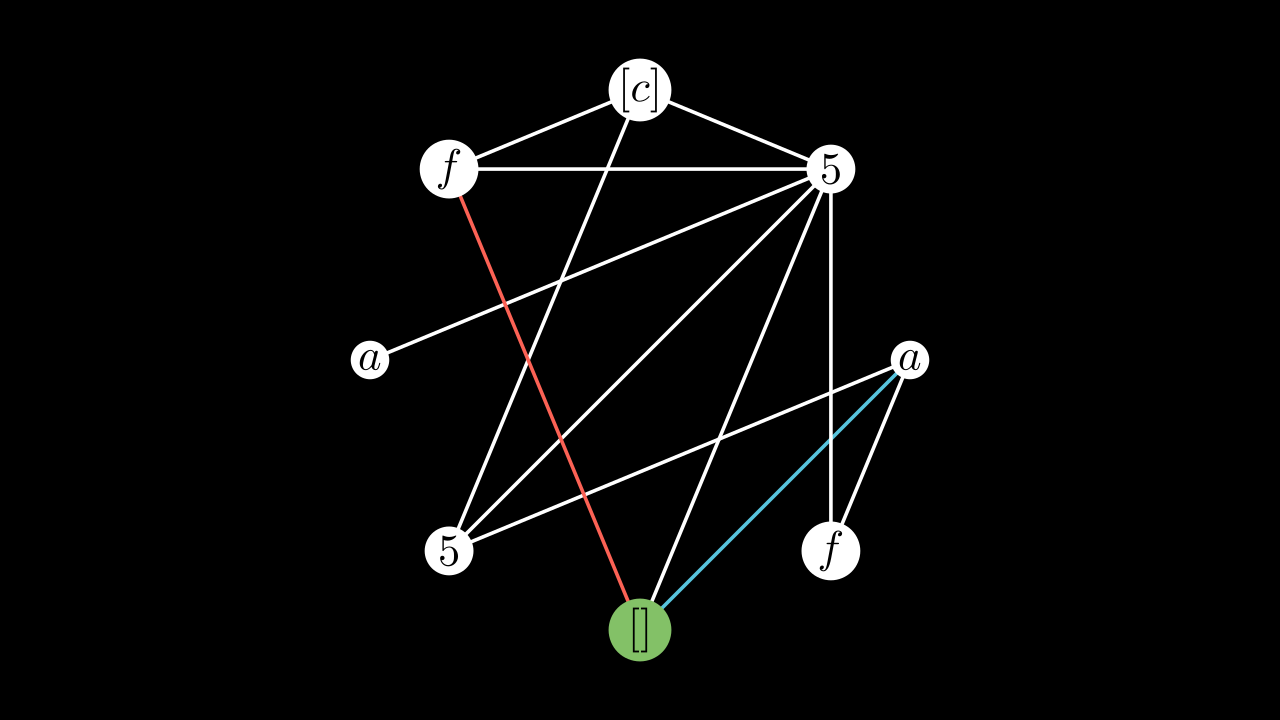

In [ ]:
class LabeledModifiedGraph(Scene):
    def construct(self):
        vertices = [1, 2, 3, 4, 5, 6, 7, 8]
        values = ['a','5','[c]', 'f','a','5','[]', 'f']
        edges = [(1, 7), (1, 8), (2, 3), (2, 4), (2, 5),
                 (2, 8), (3, 4), (6, 1), (6, 2),
                 (6, 3), (7, 2), (7, 4)]
        print({i: label for i, label in zip(vertices, values)})
        g = Graph(vertices, edges, layout="circular", layout_scale=3,
                  labels={i: label for i, label in zip(vertices, values)}, vertex_config={7: {"fill_color": GREEN, 'name':'9'}},
                  edge_config={(1, 7): {"stroke_color": BLUE},
                               (7, 4): {"stroke_color": RED}})
        self.add(g)



# don't remove below command for run button to work
%manim -qm -v WARNING LabeledModifiedGraph

In [ ]:
%%manim -qm transtext

class transtext(Scene):
    def construct(self):
        texts = [Text("Ciao").to_edge(LEFT), 
                 Text("Mauro").next_to(LEFT), 
                 Text("come").next_to(RIGHT), 
                 Text("stai").to_edge(RIGHT)]
        self.play(*[Write(t) for t in texts])
        self.wait(1)
        texts2 = [Text("Ciao").to_edge(LEFT), 
                  Text("Mauro").next_to(LEFT), 
                  Text("come").next_to(RIGHT), 
                  Text("stai").to_edge(RIGHT)]
        self.play(*[Transform(t1, t2) for t1, t2 in zip(reversed(texts), texts2)], path_arc=1)
        self.wait(2)
        

Manim Community v0.18.1

In [121]:
def test_var_kwargs(farg, **kwargs):
    print("formal arg:", farg)
    for key in kwargs:
        print("another keyword arg: %s: %s" % (key, kwargs[key]))
        
test_var_kwargs(10, ciao=10)

print(f'*{str(1)}*{str(' ')}*')

formal arg: 10
another keyword arg: ciao: 10
*1* *
